# Fined tuning models

Goal : From the dataset containing Post Event and Pre Event images with segmentation masks from MS building footprint dataset, we want to build different useful Computer Vision models like a Classifier, an Object detector and an Instance Segmentation model using different techniques like Transfer learning. A labelising work is required to build stronger model on different task. We propose to use Active Learning to find the most relevant items and Conformal prediction on Classification and Segmentation task. 

Some stats about the data : 
- more than 10 000 tiles from the raw high quality tiff images. 

Most useful files :
- damage_detection/filtered_jpeg_tiles/Post_Event_Grids_In_jpeg => 
- damage_detection/filtered_jpeg_tiles/Post_Event_Grids_mask_jpeg 
- damage_detection/filtered_jpeg_tiles/Pre_Event_Grids_In_jpeg

We consider the masks are the same for Pre and Post Event images.

To load the data from s3: 
mc cp s3/mbesnier/diffusion/damage_detection/filtered_jpeg_tiles/<folder_name> . --recursive

mc cp s3/mbesnier/diffusion/damage_detection/filtered_jpeg_tiles/Post_Event_Grids_In_jpeg . --recursive
mc cp s3/mbesnier/diffusion/damage_detection/filtered_jpeg_tiles/Pre_Event_Grids_In_jpeg . --recursive
mc cp s3/mbesnier/diffusion/damage_detection/filtered_jpeg_tiles/Post_Event_Grids_mask_jpeg . --recursive

In [1]:
import numpy as np
import csv
import json

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Others
import os
import shutil
import zipfile

from tqdm import tqdm
import glob

In [2]:
# Open the geotiff file
import re 
def extract_title_ij(filename):
    pattern_base = r"(\w+)/tile_(\d+)_(\d+).jpg"
    pattern_mask = r"(\w+)/tile_(\d+)_(\d+)_mask.jpg"
    match_base = re.search(pattern_base, filename)
    match_mask = re.search(pattern_mask, filename)
    if match_base:
        title , i, j = map(str, match_base.groups())
        return title, i, j
    if match_mask:
        title , i, j = map(str, match_mask.groups())
        return title, i, j
    return None, None, None

def load_and_visualize(image_path):
    """
    display a tif image (little tiles are recommended)
    """
    with rasterio.open(image_path) as src:
        # Read the red, green, and blue bands directly into a 3D array
        image_rgb = src.read([1, 2, 3])  # Read bands 1, 2, and 3 in a single call
        # Transpose the array for correct display (optional)
        image_rgb = image_rgb.transpose(1, 2, 0)

        title , i, j = extract_title_ij(image_path)

        # Display the RGB composite image
        plt.imshow(image_rgb)
        plt.title(f"Image from {title} at position (i={i},j={j})")
        plt.show()

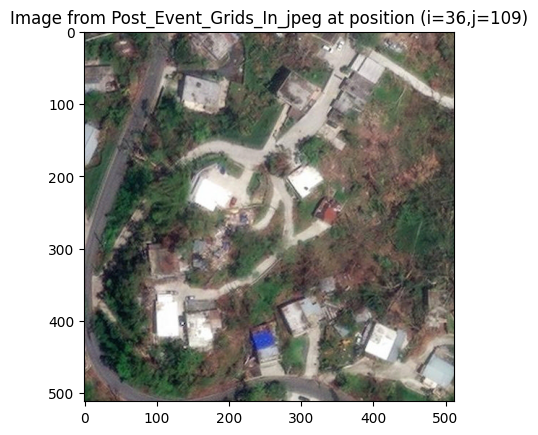

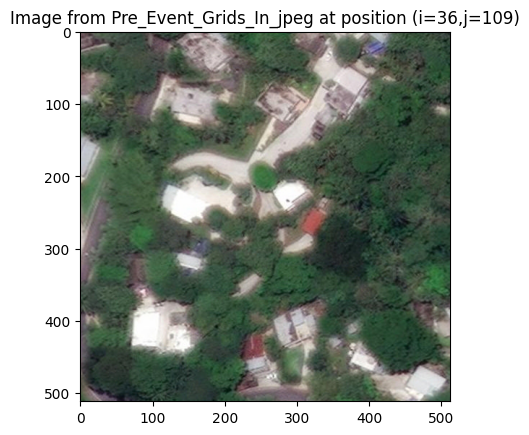

In [4]:
i = 36
j = 109

load_and_visualize(f"./data/Post_Event_Grids_In_jpeg/tile_{i}_{j}.jpg")
load_and_visualize(f"./data/Pre_Event_Grids_In_jpeg/tile_{i}_{j}.jpg")
#load_and_visualize(f"Post_Event_Grids_mask_jpeg/tile_{i}_{j}_mask.jpg")

In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set Hyperparameters 
num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Define the transformation (resize, normalize, etc.) that you want to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize the images to 224x224 pixels
    transforms.ToTensor(),            # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization with ImageNet mean/std
])

# Load dataset
full_dataset = datasets.ImageFolder(root="./data", transform=transform)

# Define a dictionary to map the original class names to new ones
# Format: {original_class_name: new_class_name}
class_rename_map = {
    'Post_Event_Grids_In_jpeg': 'Post_disaster',
    'Pre_Event_Grids_In_jpeg': 'Pre_disaster'
}
# The new mapping of the class indices based on the renaming
new_class_names = [class_rename_map[cls] for cls in full_dataset.classes]
full_dataset.classes = new_class_names
class_to_idx = {new_name: full_dataset.class_to_idx[old_name] for old_name, new_name in class_rename_map.items()}

In [18]:
# Create train and validation splits
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# Example of iterating through one batch of the training data
for images, labels in train_loader:
    print(f"Batch size: {images.size()}")
    print(f"Labels: {labels}")
    break  # Remove this break to go through the entire dataset

# Checking class names
class_names = full_dataset.classes
print(f"Classes: {class_names}")

# Optionally, get the size of the datasets
print(f"Training samples: {len(train_ds)}")
print(f"Validation samples: {len(val_ds)}")

Batch size: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 0])
Classes: ['Post_disaster', 'Pre_disaster']
Training samples: 12352
Validation samples: 3088


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard writer
from torchvision import datasets, models, transforms
import time

# Define device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load a pretrained model (e.g., ResNet) and modify for your task
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(full_dataset.classes)) # add a FCN as a head of Pre-trained model

# Move the model to the device (GPU or CPU)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set up a SummaryWriter 
writer = SummaryWriter('runs/experiment1')  # Create a folder to log everything

# Optionally, log the model graph to TensorBoard
dummy_input = torch.randn(1, 3, 224, 224).to(device)  # Example input for model graph
writer.add_graph(model, dummy_input)

# 7. Training function
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Log the training loss every 10 batches
        if batch_idx % 10 == 0:
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


# Validation function
def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    # Log validation loss and accuracy
    writer.add_scalar('Validation Loss', epoch_loss, epoch)
    writer.add_scalar('Validation Accuracy', epoch_acc, epoch)

    return epoch_loss, epoch_acc

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/onyxia/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.1MB/s]


In [ ]:
# Training loop
best_val_acc = 0.0
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, epoch)
    val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)

    # Print statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model if it has the best accuracy so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')

# 11. Close TensorBoard writer
writer.close()

# Print total training time
total_time = time.time() - start_time
print(f"Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s")
print(f"Best validation accuracy: {best_val_acc:.4f}")

In [25]:
from torchsummary import summary
summary(model,(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

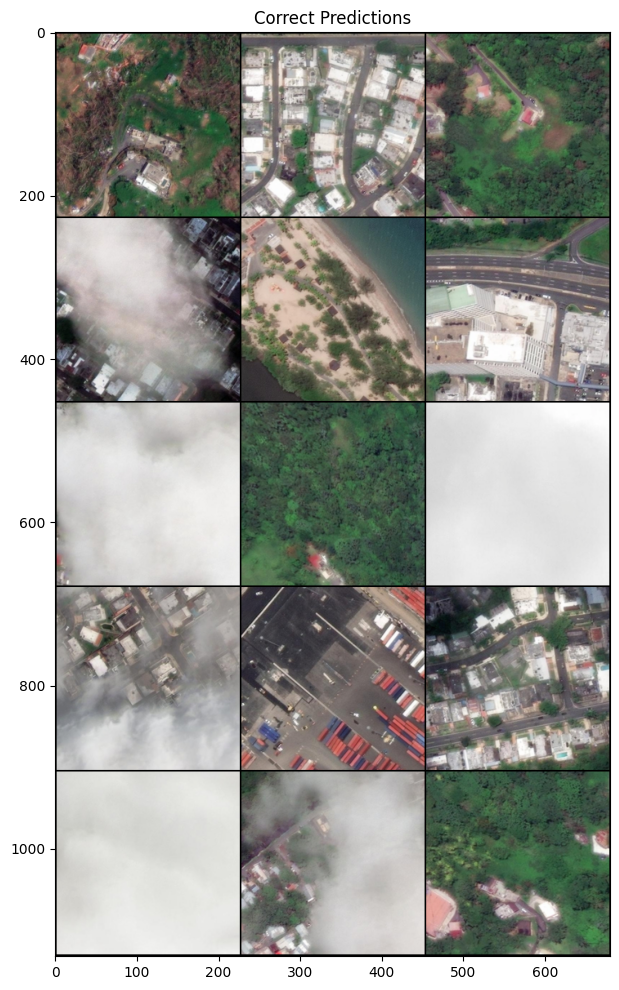

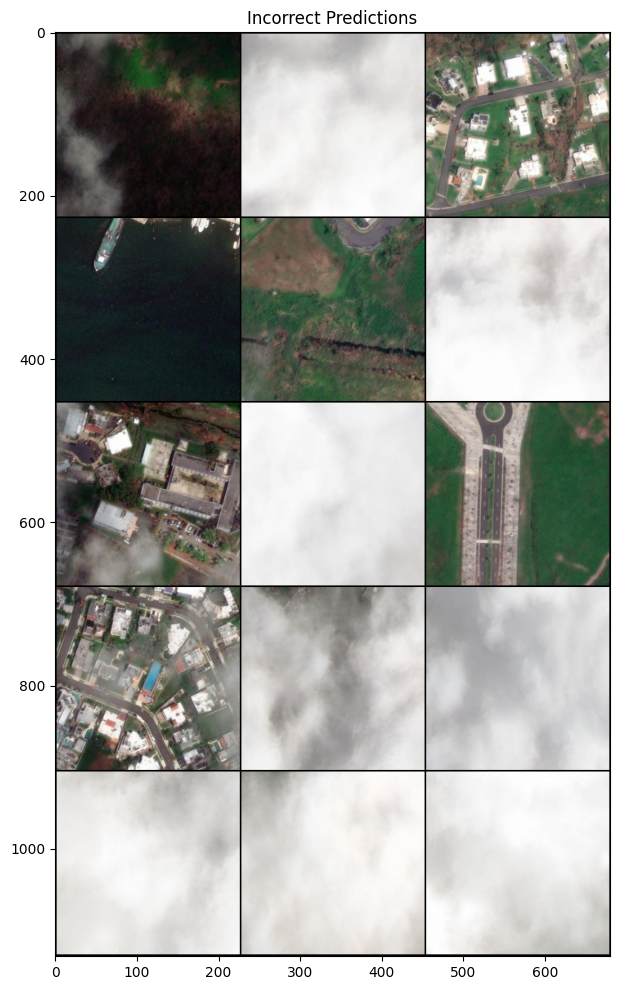

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid


def unnormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean  # Unnormalize
    return img


# Function to show images (helper function)
def imshow(img, title=None):
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

# Show images in a grid
def show_image_grid(images, labels, preds, class_names, title):
    images = [unnormalize(img) for img in images]
    images = make_grid(images, nrow=3)
    npimg = images.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


# Function to visualize model performance in a grid
def visualize_model_performance_grid(model, val_loader, device, class_names, num_images=6):
    model.eval()  # Set the model to evaluation mode
    
    correct_images = []
    correct_labels = []
    correct_preds = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Collect correct predictions
            for i in range(inputs.size(0)):
                if preds[i] == labels[i] and len(correct_images) < num_images // 2:
                    correct_images.append(inputs[i].cpu())
                    correct_labels.append(labels[i].cpu())
                    correct_preds.append(preds[i].cpu())
                
                # Collect incorrect predictions
                elif preds[i] != labels[i] and len(incorrect_images) < num_images // 2:
                    incorrect_images.append(inputs[i].cpu())
                    incorrect_labels.append(labels[i].cpu())
                    incorrect_preds.append(preds[i].cpu())

            # Stop when we have enough correct and incorrect images
            if len(correct_images) >= num_images // 2 and len(incorrect_images) >= num_images // 2:
                break

    # Show correct predictions in a grid
    if correct_images:
        show_image_grid(
            torch.stack(correct_images), 
            correct_labels, 
            correct_preds, 
            class_names, 
            title="Correct Predictions"
        )

    # Show incorrect predictions in a grid
    if incorrect_images:
        show_image_grid(
            torch.stack(incorrect_images), 
            incorrect_labels, 
            incorrect_preds, 
            class_names, 
            title="Incorrect Predictions"
        )

# Example usage:
visualize_model_performance_grid(model, val_loader, device, full_dataset.classes, num_images=30)